In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [2]:
# Load waypoints
file_name = "VL_C_F_BU_2"
output_dir = f"/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Vertical Line/{file_name}"
data_path = os.path.join(output_dir, "pose_waypoints_sampled_10hz_clean.csv")
data_path_2 = os.path.join(output_dir, "pose_waypoints_sampled_2.5hz_clean.csv")
plot_2 = False

# data_path = os.path.join(output_dir, "pose_waypoints_full.csv")

In [3]:
# Parse ground truth data
ground_truth = []
ground_truth_2 = []

# Read the CSV file with a header
with open(data_path, "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        ground_truth.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])

# Read the CSV file with a header
with open(data_path_2, "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        ground_truth_2.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])
        
gt_array = np.array(ground_truth)
gt_array_2 = np.array(ground_truth_2)

In [4]:
len(gt_array)

19

In [5]:
## Prediction function, for later
pred_model = 'CV'

In [6]:
## Prediction

# Group data by pedestrian ID (column 1)
pedestrian_ids = np.unique(gt_array[:, 1])
predictions = {}

for ped_id in pedestrian_ids:
    # Filter data for the current pedestrian
    ped_data = gt_array[gt_array[:, 1] == ped_id]
    
    # Initialize predictions for this pedestrian
    ped_predictions = []

    ph = 4
    
    for i in range(0, len(ped_data) - 1 - ph):
        # Extract current and next timestep data
        t1, x1, y1 = ped_data[i, 0], ped_data[i, 2], ped_data[i, 3]
        t2, x2, y2 = ped_data[i + 1, 0], ped_data[i + 1, 2], ped_data[i + 1, 3]
        
        # Calculate velocity (vx, vy)
        vx = (x2 - x1) / (t2 - t1)
        vy = (y2 - y1) / (t2 - t1)

        ### PREDICTION PART ###
        
        # Predict next position assuming constant velocity
        t_next = t2 + ph * (t2 - t1)  # Assuming uniform timestep
        x_next = x2 + vx * ph * (t2 - t1)
        y_next = y2 + vy * ph * (t2 - t1)
        
        # Store the prediction
        ped_predictions.append([t_next, ped_id, x_next, y_next])

    # Store predictions for this pedestrian
    predictions[ped_id] = ped_predictions

p_x = []
p_y = []
# Print predictions for each pedestrian
for ped_id, pred in predictions.items():
    # print(f"Predictions for pedestrian {ped_id}:")
    for p in pred:
        # print(p)
        p_x.append(p[2])
        p_y.append(p[3])

# len(p_x)

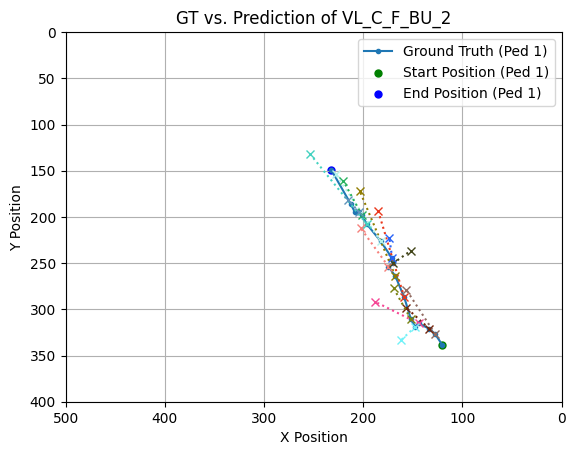

In [7]:
# # Assuming `data_array` and `predictions` are already computed as in the previous code

# # Extract x and y limits for the plot
# x_min, x_max = np.min(data_array[:, 2]), np.max(data_array[:, 2])
# y_min, y_max = np.min(data_array[:, 3]), np.max(data_array[:, 3])

# # Create the combined plot
# plt.figure(figsize=((x_max - x_min) * 0.5, (y_max - y_min) * 0.5), dpi=300)

# Set the x and y axis limits
plt.xlim(0, 500)
plt.ylim(0, 400)

# Plot ground truth trajectory (blue)
for ped_id in np.unique(gt_array[:, 1]):
    # Filter ground truth data for the pedestrian
    ped_data = gt_array[gt_array[:, 1] == ped_id]
    ped_data_2 = gt_array_2[gt_array_2[:, 1] == ped_id]

    x_gt, y_gt = ped_data[:, 2], ped_data[:, 3]
    x_gt_2, y_gt_2 = ped_data_2[:, 2], ped_data_2[:, 3]
    
    # Plot ground truth trajectory
    plt.plot(x_gt, y_gt, marker="o", linestyle="-", markersize=3,
             label=f"Ground Truth (Ped {int(ped_id)})", linewidth=1.5)
    
    if plot_2:
        plt.plot(x_gt_2, y_gt_2, marker="*", linestyle="-", markersize=3,
            label=f"Ground Truth (Ped {int(ped_id)})", linewidth=1.5)

    ## Plot predicted trajectory

    # Connect ground truth to prediction

    if ped_id in predictions:
        j = 1
        for pred in predictions[ped_id]:
            t_pred, ped_id_pred, x_pred, y_pred = pred
            
            plt.plot([x_gt[j], x_pred], [y_gt[j], y_pred], color=np.random.rand(3,),
                     marker="x", linestyle='dotted')
            j += 1

            # Othe types of plots can be added here, but be careful about multiple labels. It's better for the multi-step predictions, I think


    
    # plt.plot(p_x, p_y, marker="x", linewidth=1, linestyle='--', label='Predicted Positions', color="red") # Connect all prediction to each other
    # plt.scatter(p_x, p_y, marker="x", label='Predicted Positions', color="red") # Just show the predicted positions

# Mark start and end positions
for ped_id in np.unique(gt_array[:, 1]):
    ped_data = gt_array[gt_array[:, 1] == ped_id]
    x_gt, y_gt = ped_data[:, 2], ped_data[:, 3]
    plt.scatter(x_gt[0], y_gt[0], color="green", s=25, label=f"Start Position (Ped {int(ped_id)})")
    plt.scatter(x_gt[-1], y_gt[-1], color="blue", s=25, label=f"End Position (Ped {int(ped_id)})")
    
plt.gca().invert_yaxis()  # Invert Y to match video coordinates
plt.gca().invert_xaxis()  # Invert X to match video coordinates

# Titles and labels
plt.title(f"GT vs. Prediction of {file_name}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
plt.close()

In [ ]:
error_ade = []
error_ade_normal = []

# Calculate ADE
i = 0
for _, _, x, y in ground_truth[1+ph:]:
        pred = np.array((p_x[i], p_y[i]))
        gt = np.array((x, y))

        dist = np.linalg.norm(pred - gt, axis=-1)
        error_ade.append(dist)

        # In case of multe-step ahead prediction, all intermediate step sizes all considered. Another option is just to consider the direct distance to from origin gt to the prediction's corresponding gt, which is not considered here.

        steps_size = 0
        for j in range(1, ph + 1):
            step_start = np.array((ground_truth[i + j][2], ground_truth[i + j][3]))
            step_end = np.array((ground_truth[i + j + 1][2], ground_truth[i + j + 1][3]))

            steps_size += np.linalg.norm(step_end - step_start, axis=-1)

        # step_start = np.array((ground_truth[i + 1][2], ground_truth[i + 1][3]))
        # step_end = np.array((ground_truth[i + 2][2], ground_truth[i + 2][3]))
        # step_size = np.linalg.norm(step_end - step_start, axis=-1)

        error_ade_normal.append(dist / steps_size)
        
        i += 1

ade_avg = np.average(error_ade)
print('Average prediction error: {:.2f}'.format(ade_avg))

ade_avg_normal = np.average(error_ade_normal)
print('Average prediction error normalized: {:.2f}'.format(ade_avg_normal))

# Make an empty dataframe to store the error values in next steps
results_df = pd.DataFrame()

Average prediction error: 42.31
Average prediction error normalized: 1.04


In [ ]:
# # Define file names and data paths
# file_names = ["DL_C_F_BRTL_1", "DL_C_F_BRTL_2", "DL_C_F_BRTL_3", "DL_C_F_BRTL_4", "DL_C_F_BRTL_5", "DL_C_F_BRTL_6"]
# data_files = ["pose_waypoints_sampled_10hz_clean.csv", "pose_waypoints_sampled_2.5hz_clean.csv", "pose_waypoints_full_clean.csv"]

# Directory for datasets
base_dir = "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Vertical Line"

# Placeholder for results
results = []

# Loop through file names and data files
for root, dirs, files in os.walk(base_dir):

    dataset_name = root.split("/")[-1]
    if dataset_name.startswith('x_'):
        continue

    for file in files:

        if file.endswith("_raw.csv"):
            continue
        
        data_path = os.path.join(root, file)

        # Load data and calculate prediction error
        try:
            # Parse ground truth data
            ground_truth = []

            # Read the CSV file with a header
            with open(data_path, "r") as csvfile:
                reader = csv.DictReader(csvfile)
                for row in reader:
                    ground_truth.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])
                    
            gt_array = np.array(ground_truth)

            # Group data by pedestrian ID (column 1)
            pedestrian_ids = np.unique(gt_array[:, 1])
            predictions = {}

            for ped_id in pedestrian_ids:
                # Filter data for the current pedestrian
                ped_data = gt_array[gt_array[:, 1] == ped_id]
                
                # Initialize predictions for this pedestrian
                ped_predictions = []
                
                for i in range(len(ped_data) - 1):
                    # Extract current and next timestep data
                    t1, x1, y1 = ped_data[i, 0], ped_data[i, 2], ped_data[i, 3]
                    t2, x2, y2 = ped_data[i + 1, 0], ped_data[i + 1, 2], ped_data[i + 1, 3]
                    
                    # Calculate velocity (vx, vy)
                    vx = (x2 - x1) / (t2 - t1)
                    vy = (y2 - y1) / (t2 - t1)
                    
                    # Predict next position assuming constant velocity
                    t_next = t2 + (t2 - t1)  # Assuming uniform timestep
                    x_next = x2 + vx * (t2 - t1)
                    y_next = y2 + vy * (t2 - t1)
                    
                    # Store the prediction
                    ped_predictions.append([t_next, ped_id, x_next, y_next])

                # Store predictions for this pedestrian
                predictions[ped_id] = ped_predictions

            p_x = []
            p_y = []
            # Print predictions for each pedestrian
            for ped_id, pred in predictions.items():
                # print(f"Predictions for pedestrian {ped_id}:")
                for p in pred:
                    # print(p)
                    p_x.append(p[2])
                    p_y.append(p[3])

            
            error_ade = []
            error_ade_normal = []

            # Calculate ADE
            i = 0
            for _, _, x, y in ground_truth[2:]:
                    pred = np.array(p_x[i], p_y[i])
                    gt = np.array((x, y))

                    dist = np.linalg.norm(pred - gt, axis=-1)
                    error_ade.append(dist)

                    step_start = np.array((ground_truth[i + 1][2], ground_truth[i + 1][3]))
                    step_end = np.array((ground_truth[i + 2][2], ground_truth[i + 2][3]))

                    step_size = np.linalg.norm(step_end - step_start, axis=-1)
                    error_ade_normal.append(dist / step_size)

                    i += 1

            
            ade_avg = np.average(error_ade)
            # print('Average prediction error: {:.2f}'.format(ade_avg))

            ade_avg_normal = np.average(error_ade_normal)
            # print('Average prediction error normalized: {:.2f}'.format(ade_avg_normal))

            
            # Append result
            results.append({
                "path_type": dataset_name[:4],
                "acceleration_type": dataset_name.split("_")[2],
                "path_direction": dataset_name.split("_")[3],
                "path_number": dataset_name.split("_")[4],
                "sample_rate": file.split("_")[-2],
                "ph": ph,
                "prediction_model": pred_model,
                "average_error": ade_avg,
                "average_error_normal": ade_avg_normal
            })

            # print(f"Processed {file_name} with {data_file}: Average Error = {ade_avg}")
        except Exception as e:
            print(f"Error processing {dataset_name} with {file}: {e}")

# Display results
for result in results:
    print(result)

In [ ]:
# Remove duplicate rows based on all columns and keep the last occurrence
results_df = pd.concat([results_df, pd.DataFrame(results)]).drop_duplicates(keep='last').reset_index(drop=True)
# df_filtered = results_df[results_df['data_file'].str.endswith('2.5hz_clean.csv')]

# Display the DataFrame
results_df
# df_filtered


In [ ]:
# results_df_filtered = results_df[results_df['sample_rate'] == '10hz']
results_df.groupby([
    'path_type',
    'acceleration_type',
    'sample_rate'
                    ]).agg({'average_error': ['mean', 'std'],
    'average_error_normal': ['mean', 'std']}).reset_index()

In [ ]:
# Some draft plots
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Grouped bar plot for average_error by acceleration type
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='acceleration_type', y='average_error', ci=None)
plt.title('Effect of Acceleration Type on Average Error (ADE)')
plt.xlabel('Acceleration Type')
plt.ylabel('Average Error (ADE)')
plt.grid(True)
plt.show()

# Grouped bar plot for average_error_normal by acceleration type
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='acceleration_type', y='average_error_normal', ci=None)
plt.title('Effect of Acceleration Type on Normalized Average Error (ADE)')
plt.xlabel('Acceleration Type')
plt.ylabel('Normalized Average Error (ADE)')
plt.grid(True)
plt.show()

# Box plot for average_error by path direction
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='path_direction', y='average_error')
plt.title('Effect of Path Direction on Average Error (ADE)')
plt.xlabel('Path Direction')
plt.ylabel('Average Error (ADE)')
plt.grid(True)
plt.show()

# Box plot for average_error_normal by path direction
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='path_direction', y='average_error_normal')
plt.title('Effect of Path Direction on Normalized Average Error (ADE)')
plt.xlabel('Path Direction')
plt.ylabel('Normalized Average Error (ADE)')
plt.grid(True)
plt.show()

# Scatter plot for average_error vs. sample_rate
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='sample_rate', y='average_error', hue='path_type', style='acceleration_type')
plt.title('Effect of Sample Rate on Average Error (ADE)')
plt.xlabel('Sample Rate')
plt.ylabel('Average Error (ADE)')
plt.grid(True)
plt.legend(title='Path Type & Acceleration')
plt.show()

# Scatter plot for average_error_normal vs. sample_rate
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='sample_rate', y='average_error_normal', hue='path_type', style='acceleration_type')
plt.title('Effect of Sample Rate on Normalized Average Error (ADE)')
plt.xlabel('Sample Rate')
plt.ylabel('Normalized Average Error (ADE)')
plt.grid(True)
plt.legend(title='Path Type & Acceleration')
plt.show()